In [1]:
# !pip install nltk
# !pip install pandas
# !pip install matplotlib
# import nltk
# nltk.download('vader_lexicon')

In [2]:
# !pip install seaborn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
data=pd.read_csv('./Reviews.csv')
data=data.head(500)

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
from tqdm.notebook import tqdm
sia=SentimentIntensityAnalyzer()

In [7]:
example=data['Text'][50]
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [8]:
res={}
for i ,row in tqdm(data.iterrows(),total=len(data)):
    text=row['Text']
    idd=row['Id']
    res[idd]=sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
vader=pd.DataFrame(res).T
vader=vader.reset_index().rename(columns={'index':'Id'})
vader=vader.merge(data,how='left')

In [10]:
vader.head(1)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.0,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


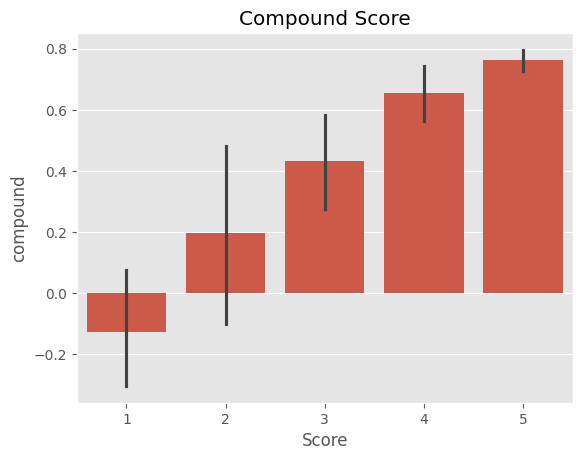

In [11]:
ax=sns.barplot(data=vader,x='Score',y='compound')
ax.set_title('Compound Score')
plt.show()

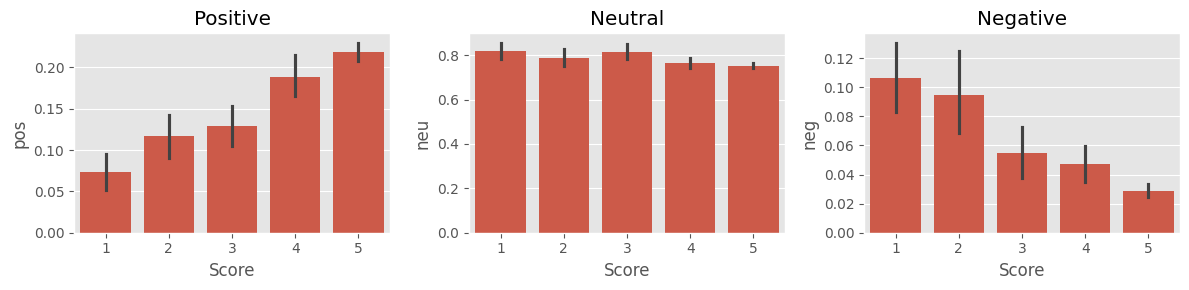

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vader, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vader, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vader, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [13]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\Admin\Documents\Projects\aiml_\LLM_learn\d\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [16]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [17]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [18]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(data, how='left')
results_df.head(1)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.0,0.695,0.305,0.9441,0.009624,0.04998,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


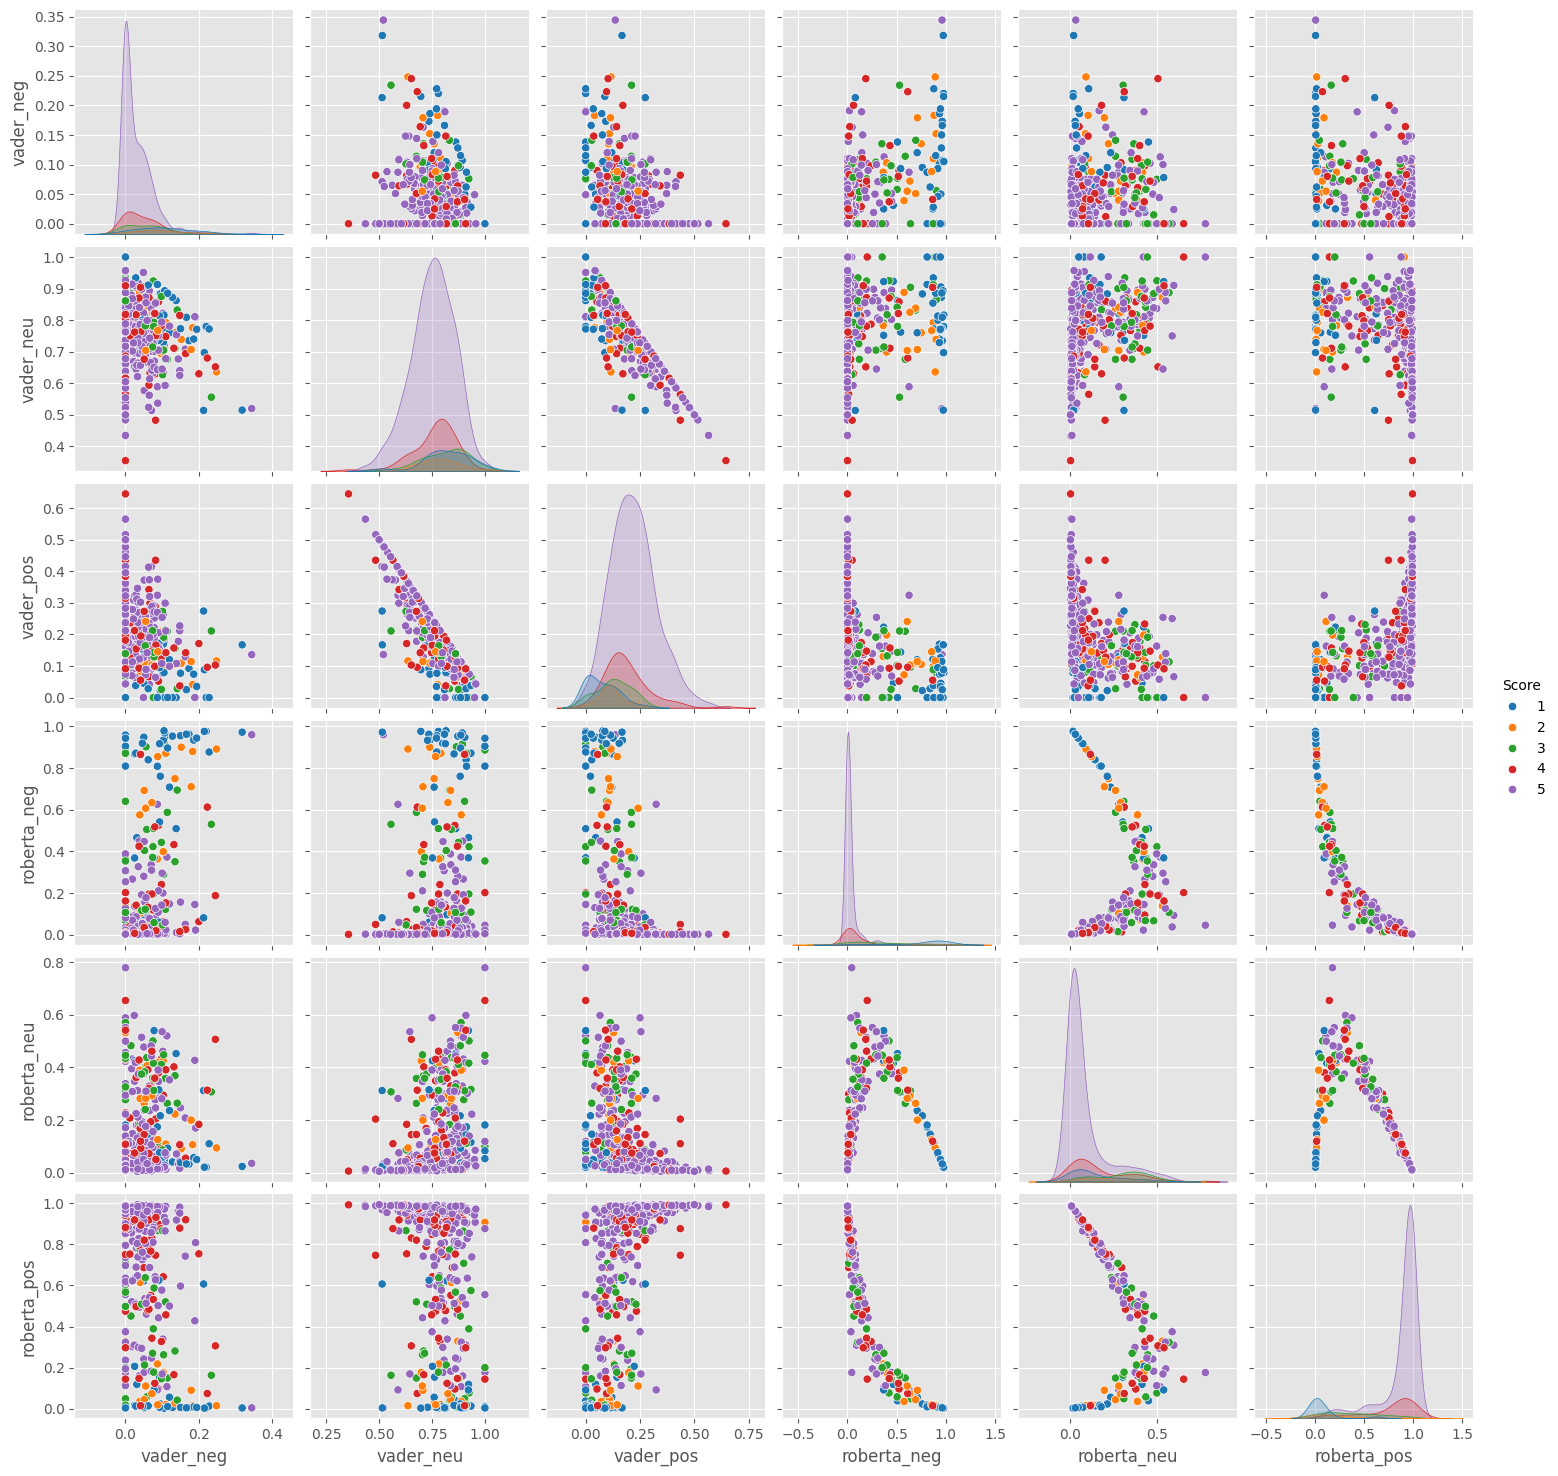

In [20]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [23]:
results_df.query('Score==1').sort_values('roberta_pos',ascending=False)['Text']

252    I felt energized within five minutes, but it l...
206    To me, these are nothing like the regular Alto...
322    So we cancelled the order.  It was cancelled w...
163    Seriously this product was as tasteless as the...
73     Buyer Beware Please! This sweetener is not for...
12     My cats have been happily eating Felidae Plati...
214    Hey, the description says 360 grams - that is ...
152    These singles sell for $2.50 - $3.36 at the st...
1      Product arrived labeled as Jumbo Salted Peanut...
211    As with canidae, Felidae has also changed thei...
309    The package came with the label torn off and n...
227    This candy is not as described. The middle is ...
265    I used to buy this sugar for years. I do not e...
359    A very bitter tasting coffee even when enhance...
280    I paid $1.79 for a 2 ounce pkg of these at lun...
62     Arrived in 6 days and were so stale i could no...
333    Serveice delivery with the seller was excellen...
329    I received the items in 

In [24]:
results_df.query('Score==5').sort_values('roberta_neg',ascending=False)['Text']

69     this was sooooo deliscious but too bad i ate e...
79     i know i cannot make tea this good.  granted, ...
24     I have lived out of the US for over 7 yrs now,...
262    "Sugar in the Raw"(tm) Please Harvest Cane w/o...
226    Took me one or two to get used to the pickle t...
                             ...                        
229    I'm trying several of the Wu Yi teas. I like t...
196    These mints are really strong and have a great...
369    Green Mountain is my favorite brand. Nantucket...
133    i have bought allot of different flavors and t...
240    Hi, I have to have black tea everyday. I have ...
Name: Text, Length: 337, dtype: object

In [25]:
#Khatam